<a href="https://colab.research.google.com/github/RiboRings/neurogenomics/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Part 1 - Normalization of sequencing data

## Part A: TMM Normalization

In [ ]:
pasilla = pd.read_csv("/content/pasilla_gene_counts.tsv", sep="\t", index_col=0)

In [ ]:
def TMM_normalization(X, Y, D=0.2):

  idx0 = np.where((X != 0) & (Y != 0))
  X = X[idx0]
  Y = Y[idx0]

  M = np.log(Y / X)
  Wi = np.sqrt((X + Y) / 2)

  lower_quantile = np.quantile(M, D/2)
  upper_quantile = np.quantile(M, 1 - D / 2)

  D2 = np.where((M > lower_quantile) & (M < upper_quantile))
  trimed_m = M[D2]
  trimed_Wi = Wi[D2]

  sorted_idx = np.argsort(trimed_m)
  sorted_m = trimed_m[sorted_idx]
  sorted_w = trimed_Wi[sorted_idx]

  tmm = np.sum(sorted_w * sorted_m) / np.sum(sorted_w)
  factor = np.exp(tmm)
  normalized_Y = Y / factor

  fig, axes = plt.subplots(1, 2, sharey=True)

  fig.set_figwidth(10)
  fig.set_figheight(3)

  axes[0].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[0].hist(Y, bins=100, range=[0, 1000], histtype="step", label="Y")

  axes[0].set_xlabel("Gene Expression")
  axes[0].set_ylabel("Gene Count")
  axes[0].set_title("Vectors histogram before normalization")
  axes[0].legend()

  axes[1].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[1].hist(normalized_Y, bins=100, range=[0, 1000], histtype="step", label="Normalized_Y")

  axes[1].set_xlabel("Gene Expression")
  axes[1].set_title("Vectors histogram after normalization")
  axes[1].legend()

  plt.tight_layout()

  return X, normalized_Y, factor

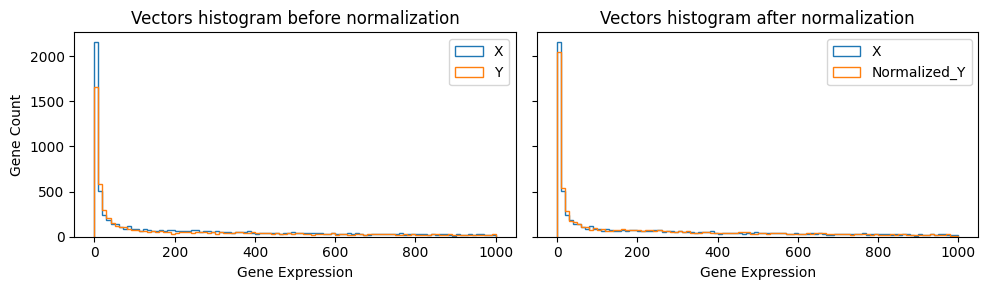

In [ ]:
X = pasilla["untreated1"].to_numpy()
Y = pasilla["untreated2"].to_numpy()

X, norm_Y, factor = TMM_normalization(X, Y)

Quantile normalization

## Part B: Quantile Normalisation

In [ ]:
def quantile_normalisation(X, Y):

  A = np.vstack([X, Y]).T

  order = A.argsort(axis=0)
  ranks = order.argsort(axis=0)

  sorted_A = np.sort(A, axis=0)
  row_mean = np.mean(sorted_A, axis=1)

  norm_A = np.zeros_like(A).astype(float)

  for rank in range(row_mean.size):

    norm_A[ranks == rank] = row_mean[rank]

  norm_X, norm_Y = norm_A[:, 0], norm_A[:, 1]

  fig, axes = plt.subplots(1, 2, sharey=True)

  fig.set_figwidth(10)
  fig.set_figheight(3)

  axes[0].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[0].hist(Y, bins=100, range=[0, 1000], histtype="step", label="Y")

  axes[0].set_xlabel("Gene Expression")
  axes[0].set_ylabel("Gene Count")
  axes[0].set_title("Vectors histogram before normalization")
  axes[0].legend()

  axes[1].hist(norm_X, bins=100, range=[0, 1000], histtype="step", label="Normalized_X")
  axes[1].hist(norm_Y, bins=100, range=[0, 1000], histtype="step", label="Normalized_Y")

  axes[1].set_xlabel("Gene Expression")
  axes[1].set_title("Vectors histogram after normalization")
  axes[1].legend()

  plt.tight_layout()

  return norm_X, norm_Y

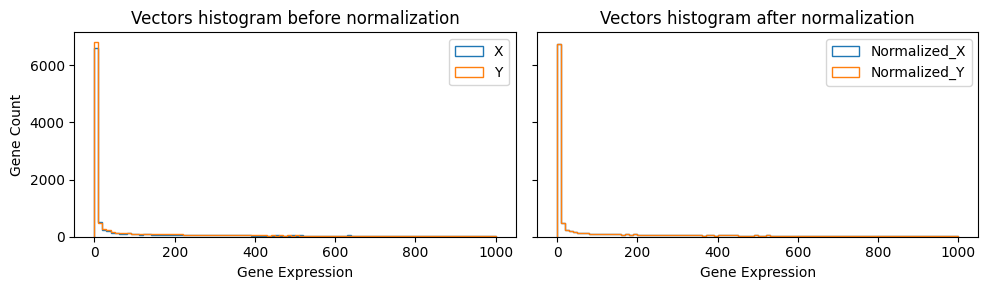

In [ ]:
pasilla = pd.read_csv("/content/pasilla_gene_counts.tsv", sep="\t", index_col=0)
X = pasilla["untreated1"].to_numpy()
Y = pasilla["treated2"].to_numpy()

norm_X, norm_Y = quantile_normalisation(X, Y)

# Part 2

In [ ]:
circ_df = pd.read_csv("CircadianRNAseq.csv")

circ_df.index = circ_df['GeneSymbol'].astype('str').str.cat(circ_df.groupby('GeneSymbol').cumcount().add(1).astype('str'), sep='_')
circ_df = circ_df.drop(columns=["RefSeqID", "GeneSymbol"])
circ_mat = circ_df.to_numpy()

<ipython-input-50-fb06f6544ee7>:9: RuntimeWarning: invalid value encountered in divide
  norm_powers = powers / np.sum(powers)


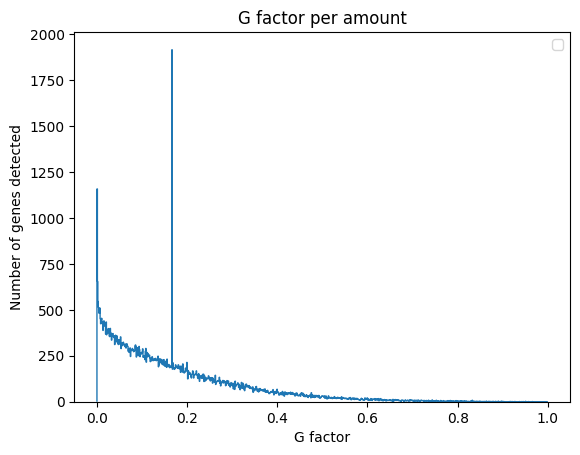

In [ ]:
from scipy.fftpack import fft

def compute_powers(time_series):  # Compute G factors

    powers = fft(time_series)
    powers = np.abs(powers) ** 2

    powers = powers[1:(1 + len(powers) // 2)]
    norm_powers = powers / np.sum(powers)

    return norm_powers

# Obtain G factor for every gene in assay
power_mat = np.apply_along_axis(compute_powers, 1, circ_mat)
power_mat = power_mat[~np.isnan(power_mat)]

# Sort genes by their 24-hour frequency power
sorted_powers = np.sort(power_mat)[::-1]

# Create and plot the G factor array
G_factor_array,_,_= plt.hist(sorted_powers, bins=1000, range=[0, 1], histtype="step") # Number of genes detected for each gene

plt.xlabel("G factor")
plt.ylabel("Number of genes detected")
plt.title("G factor per amount")

89.016


Text(0.5, 1.0, 'G factor per amount')

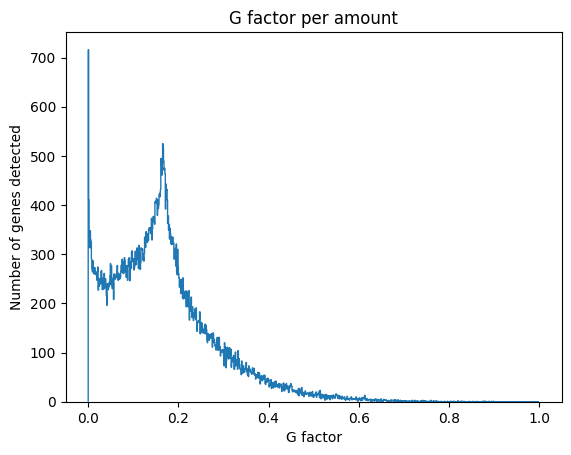

In [ ]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

shuffled_mat = shuffle_along_axis(circ_mat, axis=0)


# Obtain G factor for every gene in assay
power_mat = np.apply_along_axis(compute_powers, 1, shuffled_mat)
power_mat = power_mat[~np.isnan(power_mat)]

# Create and plot the G factor array
G_factor_array,_,_= plt.hist(sorted_powers, bins=1000, range=[0, 1], histtype="step") # Number of genes detected for each gene

print(G_factor_array.sum() / G_factor_array.size)

plt.xlabel("G factor")
plt.ylabel("Number of genes detected")
plt.title("G factor per amount")